# Solving the "Hamper Problem" with a Genetic Algorithm

The following notebook outlines the creation of a Genetic Algorithm (GA) to solve a problem proposed to me by a co-worker that I will refer to as the "hamper problem". The hamper problem is an optimisation problem whene you must create multiple hampers from a list of items while minimising the difference in their value from a target value (more information is provided below). The choice of a Genetic Algorithm for this problem was more out of interest in the approach than it being the best suited optimisation method. I had been reading about the use of GAs in hyperparameter optimisation and neuro-evolutionary learning at the time, which prompted the choice.

The problem was proposed as follows:

>A charity purchased some bulk packs, each pack contains 1 or more items. They want to put together as many hampers as they can, with the costs ideally of ¥5000, and they're all as even as possible, so minimise the sum of the absolute difference of the hamper cost to ¥5000 across all hampers. Design the hampers with no duplicate items.`

I'll be using the following packages.

In [1]:
import json

from tabulate import tabulate
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_style("darkgrid")

## Table of Contents

 1. [Problem outline](#problem_outline)
 2. [Data](#data)
 3. [Initial Processing](#initial_processing)
 4. [Building the Genetic Algorithm](#bulding_ga)
 5. [Running the Genetic Algorithm](#running_ga)

## 1. Problem Summary <a name="problem_outline"></a>

I have summarised the problem as follows, with a few assumptions that would need clarifying in a real world scenario.

__Goals:__
- Create hampers from the provided list of items
- Minimise the sum of the absolute difference of the hamper cost to ¥5000 across all hampers
    - This takes priority over anything else e.g. the number of hampers (assumed)

__Constraints:__
- Hampers cannot contain duplicate items
- All items must be use (assumed)

__Ouput:__
- Ideal number of hampers
- Sum of the absolute difference of the hamper cost to ¥5000 across all hampers 
    - I will reefer to this as sum cost difference from here on for brevity
- Items in each hamper

## 2. Data <a name="data"></a>
A CSV file has been provided for this problem containing information on the "bulk packs" that the charity has purchased. I have calculated the "total units" and "price per unit" in advance, we'll need to know these to solve the problem. I'll read the data into a pandas dataframe. You can see the last 5 items below (there are 15 in total).

In [2]:
df = pd.read_csv("CharityBulkPurchaseList.csv")
df.tail()

,item,brand,units per pack,price per pack,quantity of packs,total units,price per unit
10,Tea,Superior,5,2720,2,10,544.0
11,Tofu,Gourmet Choice,1,1580,10,10,1580.0
12,Tomato sauce,Best Family,1,190,10,10,190.0
13,UHT milk,Atlantic,6,4560,2,12,760.0
14,Vegetable oil,Crafco,12,10020,1,12,835.0


We'll also need to know the total amount spent on all of these items in the section below so I'll calculate that here.

In [3]:
# Price per pack x quantity of packs gives us the value of all units of that item
# The sum of this gives the total value of all items bought by the charity
total_item_value = ( df["price per pack"] * df["quantity of packs"] ).sum()

print(f"Total value of all items: ¥{total_item_value}")

Total value of all items: ¥126709


## 3. Initial Processing <a name="intial_processing"></a>

The availale information is enough to determine both the number of hampers we should make and the best possible sum cost difference. Knowing these narrows our search space and gives us something to aim for in our optimisation.

### Ideal number of hampers

Determining the number of hampers we should be making is fairly simple. We know the total value of the items that will be distributed between the hampers and that we want the hampers to ideally be worth 5000. Therefore, we can find the ideal number of hampers by finding how many times 5000 goes into the total value of the items and rounding to the nearest whole number.

In [4]:
target_hamper_value = 5000

# We can make n_hampers_unrounded hampers if all hampers are the target value
n_hampers_unrounded = total_item_value / target_hamper_value
# Round to nearest whole number since we can't make a fraction of a hamper
n_hampers = round(n_hampers_unrounded)

print(f"Ideal number of hampers = {n_hampers_unrounded} = {n_hampers} hampers")

Ideal number of hampers = 25.3418 = 25 hampers


### Best possible sum cost difference
The amount we had to round up/down by represents the fraction of a hamper that is either taken from the other hampers (if we round up) or distributed among the other hampers (if we round down). Thereofre we can calculate the theoretical best sum cost difference by multiplying the rounding amount by 5000. 

In [5]:
rounding_amount = n_hampers_unrounded - n_hampers
cost_diff2 = abs(round(rounding_amount*5000))

print(f"Ideal sum cost diff = ¥{cost_diff2}")

Ideal sum cost diff = ¥1709


### Sum cost difference vs Number of hampers
The theoretical best sum cost difference can also be calculated as follows for any number of hampers.

$$ \Delta = | \sum_{i=1}^{n_{i}}p_{item} -  n_{hampers} \times 5000 | $$

This allows use to calculate the sum cost difference for a range of hamper numbers. In a real world scenario this would be worth looking at to understand the trade-off between number of hampers and sum cost difference (e.g. we may tolerate a slightly higher sum cost difference if we can make an additional hamper).

In [6]:
hampers = np.arange(20, 31)

# This is the equation described above, total_item_value was calculated earlier
cost_diff = np.abs(total_item_value - hampers * 5000)
cost_diff

array([26709, 21709, 16709, 11709,  6709,  1709,  3291,  8291, 13291,
       18291, 23291])

The values calculated above are plotted against the corresponding number of hampers below.

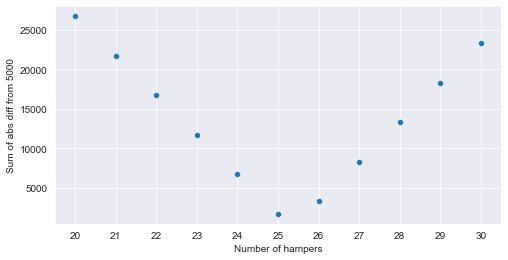

In [7]:
%matplotlib inline
fig, ax = plt.subplots(figsize=[8, 4])
sns.scatterplot(x=hampers, y=cost_diff, ax=ax)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlabel("Number of hampers")
ax.set_ylabel("Sum of abs diff from 5000")
plt.show()

## 4. Building the Genetic Algorithm <a name="building_ga"></a>

A Genetic Algorithm is a type of evolutionary algorithm that was inspired by natural selection. This algorithm will look to evolve an initial set of possible solutions (in this case randomised) to an optimised solution. It does this by "breeding" and "mutating" the best solutions (refered to as chromosomes) over multiple generations. 

The Genetic Algorithm used for this problem will take the following steps (This is visualised in the diagram below):
* __Step 1 - Initialise population__: This is done at the start of the process and provides an initial population of solutions for the algorithm to work with. In this case it will be a set of psuedo-random solutions that fit the constraits of the problem (e.g. no duplicate items in a hamper).
* __Step 2 - Fitness calculation__: The fitness calculation provides a metric to score which chromosomes are performing the best. In this case it will be the sum of the absolute difference from 5000 across all hampers.
* __Step 3 - Check if it should terminate__: Determine if the target fitness has been met or some other limit reached (e.g. total number of generations or no improvement in n generations).
* __Step 4 - Selection__: Select the fittest solutions to make the next generation
* __Step 5 - Crossover__: Combine fittest "parent" solutions to create new solutions (parents will also be in the next generation)
* __Step 6 - Mutation__: Randomly change parts of the solutions for some of the new population.
* __Repeat from Step 2__ until a termination criterum is met

<img src="./GAProcessDiagram.png" width=300/>

Note: Genetic Algorithms will find __an__ optimised solution not always the most optimal solution. They can potentially give different answers each time they are run. There are other approaches better suited to finding the most optimal solution (and more efficient approaches), but I wanted to play around with this kind of algorithm.

### The Chromosome

The chromosome is how we encode our decision space for the Genetic Algorithm. How we decide to do this will have a significant bearing on the crossover and mutation steps. The values in the chromosome are called genes and are most commonly encoded using binary encoding e.g.

```
[0, 1, 0, 1, 1]
```

Other types of encoding are also used. In the case of this problem there are a number of ways we could approach the chromosome and it is not immediately obvious which is the best. I've decided on a 2d chromosome structure where the genes (items) indicate whether an item is within a hamper or not. Each row in the structure is an individual hamper and a column is an item. Below is a representation of this for 5 hampers made from 4 different items.

```
      [0, 1, 0, 1]
items [1, 1, 0, 0]
      [1, 0, 0, 1] 
        hampers
```

###  Initialisation

A genetic algorithm requires a population of solutions (chromosomes) to begin working with. These will be created randomly within the constraints of our problem. For each item we randomly set a certain number of genes to be 1 (i.e. the item is in the corresponding hamper). The number of genes that are 1 for an item is equal to the units of that item that are available. The function below creates a random solution for a single row of a chromosome (i.e. a single item).

In [8]:
def randomly_distribute_item(num_hampers: int, num_units: int) -> np.ndarray:
    """Create a random binary array where the number of 1s is equal to an item's units."""
    # All hampers that don't have the item should be zero
    num_zeros = num_hampers - num_units

    # Want the number of zeros in the hamper to be equal to the number of units
    # of an item
    item_arr = np.array([0] * num_zeros + [1] * num_units)

    # Distribution amongst hampers should be random so we have multiple different
    # solutions
    rng = np.random.default_rng()
    rng.shuffle(item_arr)

    return item_arr


# 10 of the 25 hampers will contain this item
randomly_distribute_item(25, 10)

array([0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 1, 1])

We can use the function above, along with the information provided on the bulk packs of items, to randomise each row of our chromosome.

In [9]:
def make_random_chromosome(num_hampers: int, units: list) -> np.ndarray:
    """Make a random chromosome that fits the constraints of the hamper problem."""
    chromosome = [randomly_distribute_item(num_hampers, num_units) for num_units in units]

    return np.array(chromosome)

The above function can in turn be used to create the random population that our algorithm will begin from.

In [10]:
def initialise_population(num_hampers: int, item_amounts: list, pop_size: int) -> list:
    return [make_random_chromosome(num_hampers, item_amounts)]
    population = []
    for _ in range(pop_size):
        chromosome = make_random_chromosome(num_hampers, item_amounts)
        population.append(chromosome)

### Fitness

Once we have an initial population to work with, we need a way of working out which solutions are best. This is done using a fitness calculation. In this case our's was pretty clearly defined in the problem. i.e. minimising the sum of the absolute difference of hamper cost from 5000 across all hampers. Mathematically this can be represented as

$$ Fitness = \sum_{i=1}^{n_{hampers}} | 5000 - \sum_{j=1}^{n_{items}} price_{j} | $$

Taking advantage of the binary encoded matrices that are our chromosomes we can calculate the cost of each hamper by computing the dot product of the item values and the chromosome. This works because the product effectively replaces the 1s (where there are items) with the values of the item and leaves the 0s and 0. Doing the dot product sums these products along each hamper, calculated the cost of that hamper.

$$
costs = \begin{bmatrix}2 & 3 & 4\end{bmatrix} \cdot \begin{bmatrix}
1 & 0 & 0\\
1 & 1 & 0\\
0 & 1 & 1
\end{bmatrix} \
= \begin{bmatrix}5 & 7 & 4\end{bmatrix}
$$

Aside from making us look fancy and keeping our function small, the advantage of this approach is that it is entirely based in numpy arrays and opperations, which are significantly faster that using lists etc. thanks to the C/C++/FORTRAN code that is behind numpy.

In [11]:
def fitness_calc(
    chromosome: np.ndarray,
    item_values: np.ndarray,
    target_hamper_value: float
) -> float:
    # Since our genes are binary multiplying by an array of values
    # replaces 1s with the value of the item
    hamper_value = np.dot(item_values, chromosome)
    
    # Aim is to minimise the sum of the absolute diff therefore smaller is better
    diff = np.abs(hamper_value - target_hamper_value)
    return diff.sum()

### Selection

Now we have a function for determining fitness of a solution we now need to write a function that selects solutions to use a parents for the next generation.

In [12]:
def selection(fitness: list, num_parents: int, population: list) -> list:
    """Select the fittest solutions to use as parents for the next generation."""
    # Predefine array of indivduals that will be parents for the next generation
    parents = np.empty((num_parents, population.shape[1]))
    for i in range(num_parents):
        # Finding the fittest solution
        max_fitness_idx = np.where(fitness == np.max(fitness))
        parents[i,:] = population[max_fitness_idx[0][0], :]
        # Ensuring this solution is not selected next time
        fitness[max_fitness_idx[0][0]] = -999999
    return parents

### Crossover

Crossover is the process of combining the "genetic information" of two parent solution to produce new, different solutions to the problem. There are a number of ways to do this. We 

### Mutation

### Termination

## 5. Running the Genetic Algorithm <a name="running_ga"></a>